In [ ]:
#Shuvani Choudhury(12768553)
#Purpose of code: To fit static OLS model and analyze economic policies' effects on HSI returns

In [1]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.compat import lzip
from scipy import stats
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statistics import stdev
import statsmodels.tsa.stattools as ts
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
#Read excel file and calculate the log-returns
df = pd.read_excel('Hong Kong Data.xlsx', index_col=0)
df['Stock_Price'] = 100*(np.log(df.Stock_Price) - np.log(df.Stock_Price.shift(1)))
print(df)

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-01-01          NaN       1.78                      NaN   
2015-02-01     1.884178       1.73                      NaN   
2015-03-01    -1.484907       1.94                   1633.0   
2015-04-01    12.166759       1.85                      NaN   
2015-05-01     0.742643       1.93                      NaN   
2015-06-01    -2.367726       1.92                    481.0   
2015-07-01    -7.600855       1.89                      NaN   
2015-08-01    -7.501001       1.95                      NaN   
2015-09-01    -8.339251       2.02                  50008.0   
2015-10-01     5.836924       2.02                      NaN   
2015-11-01    -0.619173       2.02                      NaN   
2015-12-01    -2.698624       1.97                  27432.0   
2016-01-01   -10.462971       2.03                      NaN   
2016-02-01    -3.083133       2.00                     

       Stock_Price  M1_Supply  Current_Account_Balance  Unemployment_Rate  \
count    65.000000  65.000000                21.000000          66.000000   
mean      0.016934   2.304462             28092.952381           0.032500   
std       4.462307   0.263409             19629.716859           0.006232   
min     -12.125473   1.730000             -9028.000000           0.028000   
25%      -2.355658   2.080000             17070.000000           0.028250   
50%       0.938357   2.410000             25798.000000           0.032000   
75%       2.660223   2.470000             41702.000000           0.033000   
max      12.166759   3.000000             71757.000000           0.062000   

       Bond_Yield  Price_Deflator       FOREX       Real_GDP     Corona  
count   66.000000       21.000000   65.000000      21.000000  66.000000  
mean     1.580091      103.285601  401.112477  659027.809524   0.106061  
std      0.425028        2.181521   39.057585   54452.107425   0.310275  
min      0

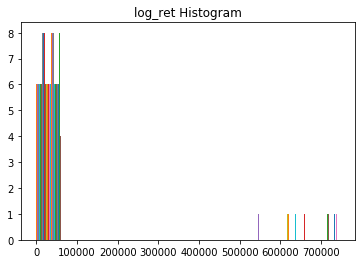

In [5]:
#Describe dataset using descriptive statistics
print(df.describe())
print(df.kurtosis());
print(df.skew());
plt.hist(df);
plt.title('log_ret Histogram');

In [6]:
#Split dataset into those regressors that need, and that don't need interpolation
df2=df.dropna()
coords = np.array(df2.iloc[2:-1,[0,1,3,4,6]])

#All regressors that need interpolation
pred_1 = np.array(df2.iloc[2:-1,2])
pred_2 = np.array(df2.iloc[2:-1,5])
pred_3 = np.array(df2.iloc[2:-1,7])

#Define individual linear interpolations
interp1 = LinearNDInterpolator(coords, pred_1)
interp2 = LinearNDInterpolator(coords, pred_2)
interp3 = LinearNDInterpolator(coords, pred_3)

#Use linear interpolation
result1 = interp1(np.array(df.iloc[2:-1,0]),np.array(df.iloc[2:-1,1]),np.array(df.iloc[2:-1,3]),np.array(df.iloc[2:-1,4]),np.array(df.iloc[2:-1,6]))
result2 = interp2(np.array(df.iloc[2:-1,0]),np.array(df.iloc[2:-1,1]),np.array(df.iloc[2:-1,3]),np.array(df.iloc[2:-1,4]),np.array(df.iloc[2:-1,6]))
result3 = interp3(np.array(df.iloc[2:-1,0]),np.array(df.iloc[2:-1,1]),np.array(df.iloc[2:-1,3]),np.array(df.iloc[2:-1,4]),np.array(df.iloc[2:-1,6]))

#Combine results into dataframe
result=np.vstack((result1,result2,result3)).T
result=pd.DataFrame(result, index=df.iloc[2:-1,[0,1,3,4,6]].index)
result.columns =['Current_Account_Balance',  'Price_Deflator',  'Real_GDP']
print(result)

            Current_Account_Balance  Price_Deflator  Real_GDP
Date                                                         
2015-03-01                      NaN             NaN       NaN
2015-04-01                      NaN             NaN       NaN
2015-05-01                      NaN             NaN       NaN
2015-06-01                      NaN             NaN       NaN
2015-07-01                      NaN             NaN       NaN
2015-08-01                      NaN             NaN       NaN
2015-09-01                  50008.0      100.755717  614251.0
2015-10-01                      NaN             NaN       NaN
2015-11-01                      NaN             NaN       NaN
2015-12-01                  27432.0      100.442179  646119.0
2016-01-01                      NaN             NaN       NaN
2016-02-01                      NaN             NaN       NaN
2016-03-01                  25798.0      103.205285  590556.0
2016-04-01                      NaN             NaN       NaN
2016-05-

In [7]:
#Combine original dataset with new interpolated regressors
interp_df = df.iloc[2:-1,[2,5,7]]
interp_df = interp_df.combine_first(result)
df3 = df.iloc[2:-1,:]
df3.iloc[:,2]=interp_df.iloc[:,0]
df3.iloc[:,5]=interp_df.iloc[:,1]
df3.iloc[:,7]=interp_df.iloc[:,2]
print(df3)

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-03-01    -1.484907       1.94                   1633.0   
2015-04-01    12.166759       1.85                      NaN   
2015-05-01     0.742643       1.93                      NaN   
2015-06-01    -2.367726       1.92                    481.0   
2015-07-01    -7.600855       1.89                      NaN   
2015-08-01    -7.501001       1.95                      NaN   
2015-09-01    -8.339251       2.02                  50008.0   
2015-10-01     5.836924       2.02                      NaN   
2015-11-01    -0.619173       2.02                      NaN   
2015-12-01    -2.698624       1.97                  27432.0   
2016-01-01   -10.462971       2.03                      NaN   
2016-02-01    -3.083133       2.00                      NaN   
2016-03-01     5.912202       2.08                  25798.0   
2016-04-01     3.326457       2.05                     

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
#Split dataset into regressors that don't and that do need interpolation
df2=df3.dropna()
coords = np.array(df2.iloc[:,[0,1,3,4,6]])
pred_1 = np.array(df2.iloc[:,2])
pred_2 = np.array(df2.iloc[:,5])
pred_3 = np.array(df2.iloc[:,7])

#Define Nearest Neighobor interpolators
interp1 = NearestNDInterpolator(coords, pred_1)
interp2 = NearestNDInterpolator(coords, pred_2)
interp3 = NearestNDInterpolator(coords, pred_3)

#Run nearest neighbor interpolation
result1 = interp1(np.array(df3.iloc[:,0]),np.array(df3.iloc[:,1]),np.array(df3.iloc[:,3]),np.array(df3.iloc[:,4]),np.array(df3.iloc[:,6]))
result2 = interp2(np.array(df3.iloc[:,0]),np.array(df3.iloc[:,1]),np.array(df3.iloc[:,3]),np.array(df3.iloc[:,4]),np.array(df3.iloc[:,6]))
result3 = interp3(np.array(df3.iloc[:,0]),np.array(df3.iloc[:,1]),np.array(df3.iloc[:,3]),np.array(df3.iloc[:,4]),np.array(df3.iloc[:,6]))

#Combine regressors into dataframe
result=np.vstack((result1,result2,result3)).T
result=pd.DataFrame(result, index=df3.iloc[:,[0,1,3,4,6]].index)
result.columns =['Current_Account_Balance',  'Price_Deflator',  'Real_GDP']
print(result)

            Current_Account_Balance  Price_Deflator  Real_GDP
Date                                                         
2015-03-01                   1633.0      101.206830  572160.0
2015-04-01                    481.0      105.297923  565750.0
2015-05-01                    481.0      105.297923  565750.0
2015-06-01                    481.0      105.297923  565750.0
2015-07-01                    481.0      105.297923  565750.0
2015-08-01                   1633.0      101.206830  572160.0
2015-09-01                  50008.0      100.755717  614251.0
2015-10-01                  25798.0      103.205285  590556.0
2015-11-01                  27432.0      100.442179  646119.0
2015-12-01                  27432.0      100.442179  646119.0
2016-01-01                  27432.0      100.442179  646119.0
2016-02-01                  27432.0      100.442179  646119.0
2016-03-01                  25798.0      103.205285  590556.0
2016-04-01                  11520.0      105.645022  585135.0
2016-05-

In [9]:
#Combine original dataset with interpolated regressors
interp_df = df3.iloc[:,[2,5,7]]
interp_df = interp_df.combine_first(result)
df3 = df.iloc[2:-1,:]
df3.iloc[:,2]=interp_df.iloc[:,0]
df3.iloc[:,5]=interp_df.iloc[:,1]
df3.iloc[:,7]=interp_df.iloc[:,2]
print(df3)

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-03-01    -1.484907       1.94                   1633.0   
2015-04-01    12.166759       1.85                    481.0   
2015-05-01     0.742643       1.93                    481.0   
2015-06-01    -2.367726       1.92                    481.0   
2015-07-01    -7.600855       1.89                    481.0   
2015-08-01    -7.501001       1.95                   1633.0   
2015-09-01    -8.339251       2.02                  50008.0   
2015-10-01     5.836924       2.02                  25798.0   
2015-11-01    -0.619173       2.02                  27432.0   
2015-12-01    -2.698624       1.97                  27432.0   
2016-01-01   -10.462971       2.03                  27432.0   
2016-02-01    -3.083133       2.00                  27432.0   
2016-03-01     5.912202       2.08                  25798.0   
2016-04-01     3.326457       2.05                  115

       Stock_Price  M1_Supply  Current_Account_Balance  Unemployment_Rate  \
count    63.000000  63.000000                63.000000          63.000000   
mean     -0.056507   2.321905             26199.476190           0.032016   
std       4.513310   0.248102             17745.291977           0.005142   
min     -12.125473   1.850000             -9028.000000           0.028000   
25%      -2.361692   2.115000             17070.000000           0.028000   
50%       0.742643   2.420000             23373.000000           0.032000   
75%       2.628619   2.475000             33459.000000           0.033000   
max      12.166759   3.000000             71757.000000           0.059000   

       Bond_Yield  Price_Deflator       FOREX       Real_GDP     Corona  
count   63.000000       63.000000   63.000000      63.000000  63.000000  
mean     1.598175      103.401517  403.412873  658968.730159   0.095238  
std      0.417025        2.214489   37.409466   50917.835294   0.295901  
min      0

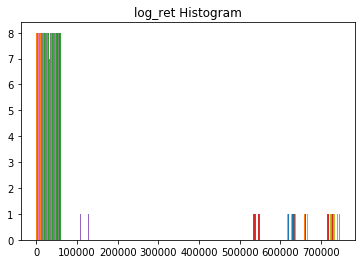

In [10]:
#Print descriptive statistics for new, interpolated dataset
print(df3.describe())
print(df3.kurtosis());
print(df3.skew());
plt.hist(df3);
plt.title('log_ret Histogram');

In [23]:
#Create additional possible regressors
df3['Cond_M1']=df3.M1_Supply*df3.Corona
df3['Cond_CAB']=df3.Current_Account_Balance*df3.Corona
df3['Cond_BY']=df3.Bond_Yield*df3.Corona
df3['CAB_lag1']=df3.Current_Account_Balance.shift(1)
df3['CAB_lag2']=df3.Current_Account_Balance.shift(2)
df3['For_lag1']=df3.FOREX.shift(1)
df3['For_lag2']=df3.FOREX.shift(2)
df3['PD_lag2']=df3.Price_Deflator.shift(2)
df3['Cond_M1lag1']=df3.Cond_M1.shift(1)
df3['Cond_CABlag1']=df3.Cond_CAB.shift(1)
df3['BY_l1']=df3.Bond_Yield.shift(1)
df3['BY_l2']=df3.Bond_Yield.shift(2)
df3['BY_l3']=df3.Bond_Yield.shift(3)
df3['M1_l1']=df3.M1_Supply.shift(1)
df3['M1_l2']=df3.M1_Supply.shift(2)
df3['M1_l3']=df3.M1_Supply.shift(3)
df3['UR_l1']=df3.Unemployment_Rate.shift(1)
df3['UR_l2']=df3.Unemployment_Rate.shift(2)
df3['UR_l3']=df3.Unemployment_Rate.shift(3)
df3['GDP_l1']=df3.Real_GDP.shift(1)
df3['GDP_l2']=df3.Real_GDP.shift(1)
df3['GDP_l3']=df3.Real_GDP.shift(1)
print(df3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-03-01    -1.484907       1.94                   1633.0   
2015-04-01    12.166759       1.85                    481.0   
2015-05-01     0.742643       1.93                    481.0   
2015-06-01    -2.367726       1.92                    481.0   
2015-07-01    -7.600855       1.89                    481.0   
2015-08-01    -7.501001       1.95                   1633.0   
2015-09-01    -8.339251       2.02                  50008.0   
2015-10-01     5.836924       2.02                  25798.0   
2015-11-01    -0.619173       2.02                  27432.0   
2015-12-01    -2.698624       1.97                  27432.0   
2016-01-01   -10.462971       2.03                  27432.0   
2016-02-01    -3.083133       2.00                  27432.0   
2016-03-01     5.912202       2.08                  25798.0   
2016-04-01     3.326457       2.05                  115

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [13]:
#Choose OLS model for studying corona's significance based on AIC, BIC, and adjusted R-squared values
y=np.array(df3.iloc[3:,0])
x=np.array(df3.iloc[3:,[1,2,3,4,5,6,7,8,15,16,28]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     3.252
Date:                Mon, 10 Aug 2020   Prob (F-statistic):            0.00222
Time:                        18:59:29   Log-Likelihood:                -155.93
No. Observations:                  60   AIC:                             335.9
Df Residuals:                      48   BIC:                             361.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.9680     35.112     -0.910      0.3

In [14]:
#Run breuschpagan test
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(6.55901569423341, 0.8335892662104432, 0.5355657229152146, 0.8691990099302598)


In [15]:
#Use available code to organize vif values for regressors in model and reduce regressors
#source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

print(calc_vif(df3.iloc[2:,[1,2,3,4,5,6,7,8,15,16,28]]))
print(calc_vif(df3.iloc[2:,[1,2,3,4,5,7,8,28]]))

                  variables          VIF
0                 M1_Supply   533.823867
1   Current_Account_Balance     6.445261
2         Unemployment_Rate   160.292991
3                Bond_Yield    39.997322
4            Price_Deflator  2771.549775
5                     FOREX  3924.496791
6                  Real_GDP  1048.582066
7                    Corona     3.542953
8                  For_lag2  3310.607921
9                   PD_lag2  2751.919785
10                   GDP_l1   719.499521
                 variables         VIF
0                M1_Supply  253.684414
1  Current_Account_Balance    5.333067
2        Unemployment_Rate  122.938609
3               Bond_Yield   35.808546
4           Price_Deflator  471.498710
5                 Real_GDP  764.803224
6                   Corona    2.977500
7                   GDP_l1  668.536686


In [16]:
#Run OLS model on less multicollinear regressors
y=np.array(df3.iloc[3:,0])
x=np.array(df3.iloc[3:,[1,2,3,4,5,7,8,28]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     2.828
Date:                Mon, 10 Aug 2020   Prob (F-statistic):             0.0112
Time:                        18:59:40   Log-Likelihood:                -161.62
No. Observations:                  60   AIC:                             341.2
Df Residuals:                      51   BIC:                             360.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -45.3957     33.543     -1.353      0.1

In [17]:
#Run breuschpagan test on new model results
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(4.7080284596398325, 0.7882777835434324, 0.5428216899137982, 0.8186387949295124)


In [18]:
#Choose and run OLS model to study individual policy effects during pandemic (choose based on AIC, BIC, and adjusted R-squared)
y=np.array(df3.iloc[3:,0])
x=np.array(df3.iloc[3:,[1,2,3,4,5,6,7,9,10,11,13,14,15,16,17,18]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     2.978
Date:                Mon, 10 Aug 2020   Prob (F-statistic):            0.00223
Time:                        18:59:44   Log-Likelihood:                -150.26
No. Observations:                  60   AIC:                             334.5
Df Residuals:                      43   BIC:                             370.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -71.9391     41.385     -1.738      0.0

In [19]:
#Run breuschpagan test on results
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(12.587489180867106, 0.702645817987639, 0.7135010694250982, 0.7649712287287276)


In [20]:
#Calculate vif values for all regressors in model and reduce multicollinearity
print(calc_vif(df3.iloc[2:,[1,2,3,4,5,6,7,9,10,11,13,14,15,16,17,18]]))
print(calc_vif(df3.iloc[2:,[1,2,3,4,7,9,10,11,17,18]]))

                  variables           VIF
0                 M1_Supply    567.276693
1   Current_Account_Balance      7.288022
2         Unemployment_Rate    614.740653
3                Bond_Yield     48.292146
4            Price_Deflator   3448.995011
5                     FOREX   8640.088828
6                  Real_GDP   1017.832369
7                    Cond_M    219.446683
8                  Cond_CAB      8.581328
9                   Cond_BY     93.734304
10                 CAB_lag2      5.392138
11                 For_lag1  16748.286151
12                 For_lag2   7058.585151
13                  PD_lag2   3118.687905
14               Cond_Mlag1     62.799247
15             Cond_CABlag1      7.863496
                 variables         VIF
0                M1_Supply  229.281060
1  Current_Account_Balance    4.836144
2        Unemployment_Rate   78.600582
3               Bond_Yield   32.835318
4                 Real_GDP  415.530155
5                   Cond_M  126.204398
6            

In [21]:
#Run OLS on less multicollinear set of regressors
y=np.array(df3.iloc[2:,0])
x=np.array(df3.iloc[2:,[1,2,3,4,7,9,10,11,17,18]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     2.662
Date:                Mon, 10 Aug 2020   Prob (F-statistic):             0.0109
Time:                        18:59:47   Log-Likelihood:                -162.01
No. Observations:                  61   AIC:                             346.0
Df Residuals:                      50   BIC:                             369.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.4911     20.442     -0.807      0.4

In [22]:
#Run Breuschpagan test on model results
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(5.857596672513345, 0.8270820305347517, 0.5311336030935675, 0.8598665272850184)
